In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [ ]:
import keras
import keras.backend as k
from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import History
from keras import callbacks

In [ ]:
def BASIC_CLEAN(file_name):
        df = pd.read_csv(file_name,sep=" ",header=None)
        df = df.dropna(axis=1,how='all')
        index_names = ['unit','time_cycle']
        settings = ["setting_"+str(i) for i in range(1,4)]
        sensor_names = ['S{}'.format(i) for i in range(1,22)] 
        column_names = index_names+settings+sensor_names
        old_names = df.columns
        df.rename(columns=dict(zip(old_names, column_names)), inplace=True)
        dropped_features = ['setting_1','setting_2','setting_3','S1','S5','S6','S10','S13','S14','S16','S18','S19']
        df.drop(dropped_features,axis=1,inplace=True)
        return df

In [ ]:

def RUL_TRAIN_CALC(training_file):
    rul = pd.DataFrame(training_file.groupby('unit')['time_cycle'].max()).reset_index()
    rul.columns = ['unit', 'max']
    training_file = training_file.merge(rul, on=['unit'], how='left')
    training_file['RUL'] = training_file['max'] - training_file['time_cycle']
    training_file.drop('max', axis=1, inplace=True)
    return training_file

In [ ]:

def RUL_TEST_CALC(df_truth,df_test):
    df_truth = pd.read_csv(df_truth, sep=" ", header=None)
    df_truth.dropna(axis=1,inplace=True)
    rul = pd.DataFrame(df_test.groupby('unit')['time_cycle'].max()).reset_index()
    rul.columns = ['unit', 'max']#rename the column as unit and max(max time cycle)
    df_truth.columns = ['more']
    df_truth['max'] = rul['max']+df_truth['more']
    df_truth.drop('more',axis=1,inplace=True)
    df_truth['unit'] = df_truth.index + 1
    df_test = df_test.merge(df_truth,on=['unit'],how='left')
    df_test['RUL']=df_test['max']-df_test['time_cycle']
    df_test.drop('max',axis=1,inplace=True)
    return df_test

In [ ]:
df_train = BASIC_CLEAN('/content/drive/MyDrive/AI-DS PROJECTS/Aircraft-Maintenance/dataset/train_FD001.txt')
df_test = BASIC_CLEAN('/content/drive/MyDrive/AI-DS PROJECTS/Aircraft-Maintenance/dataset/test_FD001.txt')

<h4> Calculate RUL( For Training File)

In [ ]:
df_train = RUL_TRAIN_CALC(df_train)
df_train.head()

,unit,time_cycle,S2,S3,S4,S7,S8,S9,S11,S12,S15,S17,S20,S21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,8.4294,393,38.90,23.4044,187


<h4> Calculate RUL (For Test Dataset)

In [ ]:
df_test = RUL_TEST_CALC('/content/drive/MyDrive/AI-DS PROJECTS/Aircraft-Maintenance/dataset/RUL_FD001.txt',df_test)

In [ ]:
df_test.head(5)

,unit,time_cycle,S2,S3,S4,S7,S8,S9,S11,S12,S15,S17,S20,S21,RUL
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,8.4052,392,38.86,23.3735,142
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,8.3803,393,39.02,23.3916,141
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,8.4441,393,39.08,23.4166,140
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,8.3917,391,39.00,23.3737,139
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,8.4031,390,38.99,23.4130,138


In [ ]:
df_train.shape,df_test.shape

((20631, 15), (13096, 15))

In [ ]:
def ACTUAL(df):
  y_true = pd.read_csv(df, delim_whitespace=True,names=["RUL"])
  y_true["unit"] = y_true.index+1
  return y_true


In [ ]:
y_true = ACTUAL('/content/drive/MyDrive/AI-DS PROJECTS/Aircraft-Maintenance/dataset/RUL_FD001.txt')

In [ ]:
y_true

,RUL,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [ ]:
y_true.shape

(100, 2)

In [ ]:
df_train.columns

Index(['unit', 'time_cycle', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
       'S15', 'S17', 'S20', 'S21', 'RUL'],
      dtype='object')

In [ ]:
feats = df_train.columns.difference(['unit', 'time_cycle','RUL'])
scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = scaler.fit_transform(df_train[feats])
df_test[feats] = scaler.fit_transform(df_test[feats])

In [ ]:


def gen_train(id_df, seq_length, seq_cols):
       
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [ ]:
sequence_length=50

In [ ]:
x = [df_train[df_train['unit']==unit] for unit in df_train['unit'].unique()]

In [ ]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['unit']==unit], sequence_length, feats)) for unit in df_train['unit'].unique()))
print(x_train.shape)


(15731, 50, 12)


In [ ]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]
  


In [ ]:
y_train = np.concatenate(list(list(gen_target(df_train[df_train['unit']==unit], sequence_length, "RUL")) for unit in df_train['unit'].unique()))
y_train.shape

(15731,)

In [ ]:


def gen_test(id_df, seq_length, seq_cols, mask_value):

    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)



In [ ]:
mask_value = 0

In [ ]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['unit']==unit], sequence_length, feats, mask_value)) for unit in df_test['unit'].unique()))
print(x_test.shape)


(100, 50, 12)


In [ ]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape


(100,)

In [ ]:
x_train.shape

(15731, 50, 12)

In [ ]:
features =x_train.shape[2]

In [ ]:

history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length,features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           45200     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 125,701
Trainable params: 125,701
Non-trai

In [ ]:
checkpoint_path ='model_checkpoints/'
checkpoints = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_freq='epoch',save_best_only=True,mode='min',verbose=0)

In [ ]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto'),checkpoints])

Epoch 1/100
442/443 [============================>.] - ETA: 0s - loss: 5785.4395 - mse: 5785.4395

443/443 [==============================] - 19s 26ms/step - loss: 5783.7319 - mse: 5783.7319 - val_loss: 5974.6543 - val_mse: 5974.6543
Epoch 2/100
439/443 [============================>.] - ETA: 0s - loss: 2535.5125 - mse: 2535.5125

443/443 [==============================] - 11s 25ms/step - loss: 2529.9285 - mse: 2529.9285 - val_loss: 2720.8020 - val_mse: 2720.8020
Epoch 3/100
439/443 [============================>.] - ETA: 0s - loss: 1178.8485 - mse: 1178.8485

443/443 [==============================] - 12s 26ms/step - loss: 1177.2653 - mse: 1177.2653 - val_loss: 1485.7161 - val_mse: 1485.7161
Epoch 4/100
443/443 [==============================] - 4s 10ms/step - loss: 817.1956 - mse: 817.1956 - val_loss: 1952.9049 - val_mse: 1952.9049
Epoch 5/100
443/443 [==============================] - 4s 8ms/step - loss: 715.0789 - mse: 715.0789 - val_loss: 1494.1381 - val_mse: 1494.1381
Epoch 6/100
442/443 [============================>.] - ETA: 0s - loss: 659.8905 - mse: 659.8905

443/443 [==============================] - 11s 25ms/step - loss: 660.5302 - mse: 660.5302 - val_loss: 1386.8682 - val_mse: 1386.8682
Epoch 7/100
443/443 [==============================] - ETA: 0s - loss: 624.8214 - mse: 624.8214

443/443 [==============================] - 11s 25ms/step - loss: 624.8214 - mse: 624.8214 - val_loss: 998.4029 - val_mse: 998.4029
Epoch 8/100
441/443 [============================>.] - ETA: 0s - loss: 596.1540 - mse: 596.1540

443/443 [==============================] - 11s 25ms/step - loss: 596.9136 - mse: 596.9136 - val_loss: 968.7925 - val_mse: 968.7925
Epoch 9/100
443/443 [==============================] - 4s 8ms/step - loss: 570.3591 - mse: 570.3591 - val_loss: 1225.0155 - val_mse: 1225.0155
Epoch 10/100
443/443 [==============================] - 4s 10ms/step - loss: 544.7502 - mse: 544.7502 - val_loss: 1172.5143 - val_mse: 1172.5143
Epoch 11/100
443/443 [==============================] - 4s 9ms/step - loss: 520.3627 - mse: 520.3627 - val_loss: 975.5641 - val_mse: 975.5641
Epoch 12/100
443/443 [==============================] - 4s 8ms/step - loss: 494.3901 - mse: 494.3901 - val_loss: 1365.7692 - val_mse: 1365.7692
Epoch 13/100
443/443 [==============================] - 4s 9ms/step - loss: 467.6181 - mse: 467.6181 - val_loss: 1064.8831 - val_mse: 1064.8831
Epoch 14/100
443/443 [==============================] - 4s 8ms/step - loss: 446.3138 - mse: 446.3138 - val_loss: 1125.2747 - val_mse: 1125.2747
Epoch 1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


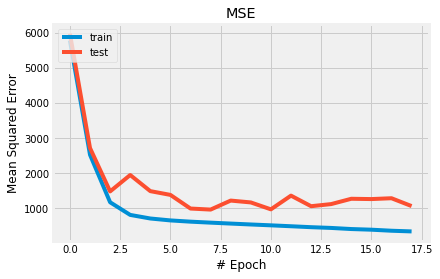

In [ ]:


plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



     


In [ ]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))


79/79 [==============================] - 1s 7ms/step - loss: 371.6288 - mse: 371.6288
MSE: 371.6287536621094


In [ ]:


scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))



     


4/4 - 0s - loss: 1272.1724 - mse: 1272.1724 - 33ms/epoch - 8ms/step
MSE: 1272.17236328125


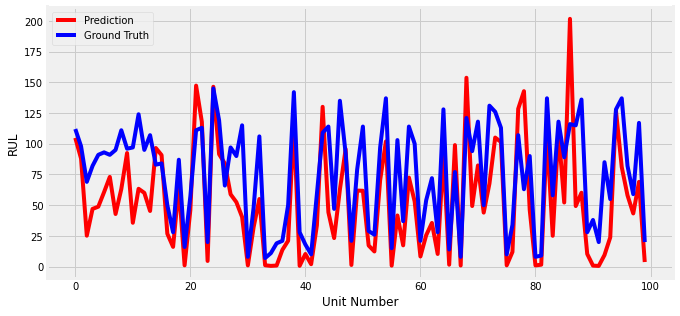

In [ ]:


y_pred_test = model.predict(x_test, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()



     


In [ ]:
model.save('predictive_model.hdf5')


Prediction

In [ ]:
model = keras.models.load_model('/content/predictive_model.hdf5')

In [ ]:
predictions1 = model.predict(x_test)

4/4 [==============================] - 6s 9ms/step


In [ ]:
results = predictions1.flatten()

In [ ]:
results.shape

(100,)

In [ ]:
df1 = pd.DataFrame(results)

In [ ]:
df1.columns = ['RUL']

In [ ]:
df1.head()

,RUL
0,104.777176
1,87.975098
2,25.201572
3,46.990646
4,48.802883


In [ ]:
df1.index = df1.index + 1

In [ ]:
df1.head()

,RUL
1,104.777176
2,87.975098
3,25.201572
4,46.990646
5,48.802883


In [ ]:
def FINAL_TOUCHES(predictions):
  results = predictions.flatten()
  df = pd.DataFrame(results)
  df.columns = ['RUL']
  df.index = df.index + 1
  return df

